## Processing of experiments result data

In [58]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import os
import math

In [59]:
# Helper function
def reduce_nesting_level(path, levels):
    """
    Recursively reduces the nesting level of a path by `levels`.

    Args:
        path (str): The path to reduce the nesting level of.
        levels (int): The number of levels to reduce.

    Returns:
        str: The reduced path.
    """
    if levels == 0:
        return path

    return reduce_nesting_level(os.path.dirname(path), levels - 1)

## Experiment 1: Valid mappings scatterplot (Eyeriss_like; AlexNet; w and w/o gating)
* Scatter and Box plots of individual valid mapping results for individual data quantization settings for chosen Eyeriss desing (with and without gating optimization) and chosen AlexNet CONV layer
* The considered scenario is found in the `../../scenarios/alexnet_eyeriss-like/mapper` folder
* You can change the desired `metric`, `design_setting` and `layer_choice` in the code

In [60]:
# Scenario path
scenario = "../../scenarios/alexnet_eyeriss-like/mapper"
# Customizable parameters
metric = "edp" # edp, energy-delay, delay-energy, energy-last-level-accesses, last-level-accesses-energy, delay-last-level-accesses, last-level-accesses-delay

### RETRIEVE DATA ###
path = os.path.join(scenario)
arch_name = scenario.split("/")[3].split("_")[1].split("-")[0]

# Define column names for the dataframe (OAVES data are typically collected by multiple threads and thus do not have a header row)
column_names = [
    "pJ/Compute",
    "Utilization",
    "Cycles",
    "Energy [uJ]",
    "EDP [J*cycle]",
    "Area [mm^2]",
    "Computes",
    "Algorithmic Computes",
    "Buffer Size",
    "Op Intensity",
    "LastLevelAccesses",
    "Buffer Size Tensor 1",
    "Buffer Size Tensor 2",
    "Buffer Size Tensor 3",
    "DRAM Word Accesses Tensor 1",
    "DRAM Word Accesses Tensor 2",
    "DRAM Word Accesses Tensor 3",
    "Compact Print of Mapping",
    "Path to Mapping.yaml"
]

oaves_dfs = [] # oaves.csv data
stats_dfs = [] # stats.csv data
# Extract results from the Eyeriss_like architecture's oaves.csv
for f in glob.glob(f"{path}/**/{metric}/**/*oaves.csv", recursive=True):
    design_setting = os.path.basename(reduce_nesting_level(f, 8))
    quant_setting = os.path.basename(reduce_nesting_level(f, 7))
    mapper_name = os.path.basename(reduce_nesting_level(f, 3))
    metric_name = os.path.basename(reduce_nesting_level(f, 2))
    topology_name = os.path.basename(reduce_nesting_level(f, 1))
    layer_name = os.path.splitext(os.path.splitext(os.path.basename(f))[0])[0]
    # print(f"arch_name: {arch_name}, design_setting: {design_setting}, quant_setting: {quant_setting}, mapper_name: {mapper_name}, metric_name: {metric_name}, topology_name: {topology_name}, layer_name: {layer_name}")
    
    arch_df = pd.read_csv(f, names=column_names)
    arch_df['Architecture'] = arch_name
    arch_df['NN topology'] = topology_name
    arch_df['Layer'] = layer_name
    arch_df['Mapper'] = mapper_name
    arch_df['Metric'] = metric_name
    arch_df['Datawidth setting'] = quant_setting
    arch_df['Design setting'] = design_setting
    oaves_dfs.append(arch_df)
oaves_df = pd.concat(oaves_dfs, axis=0, ignore_index=True)

# Extract results from the Eyeriss_like architecture's stats.csv
for f in glob.glob(f"{path}/**/{metric}/**/*stats.csv", recursive=True):
    design_setting = os.path.basename(reduce_nesting_level(f, 8))
    quant_setting = os.path.basename(reduce_nesting_level(f, 7))
    mapper_name = os.path.basename(reduce_nesting_level(f, 3))
    metric_name = os.path.basename(reduce_nesting_level(f, 2))
    topology_name = os.path.basename(reduce_nesting_level(f, 1))
    layer_name = os.path.splitext(os.path.splitext(os.path.basename(f))[0])[0]
    # print(f"arch_name: {arch_name}, design_setting: {design_setting}, quant_setting: {quant_setting}, mapper_name: {mapper_name}, metric_name: {metric_name}, topology_name: {topology_name}, layer_name: {layer_name}")
    
    arch_df = pd.read_csv(f)
    arch_df['Architecture'] = arch_name
    arch_df['NN topology'] = topology_name
    arch_df['Layer'] = layer_name
    arch_df['Mapper'] = mapper_name
    arch_df['Metric'] = metric_name
    arch_df['Datawidth setting'] = quant_setting
    arch_df['Design setting'] = design_setting
    stats_dfs.append(arch_df)
stats_df = pd.concat(stats_dfs, axis=0, ignore_index=True)

/tmp/ipykernel_7263/2014720356.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scatter_plot_df.loc[:, 'Best'] = False


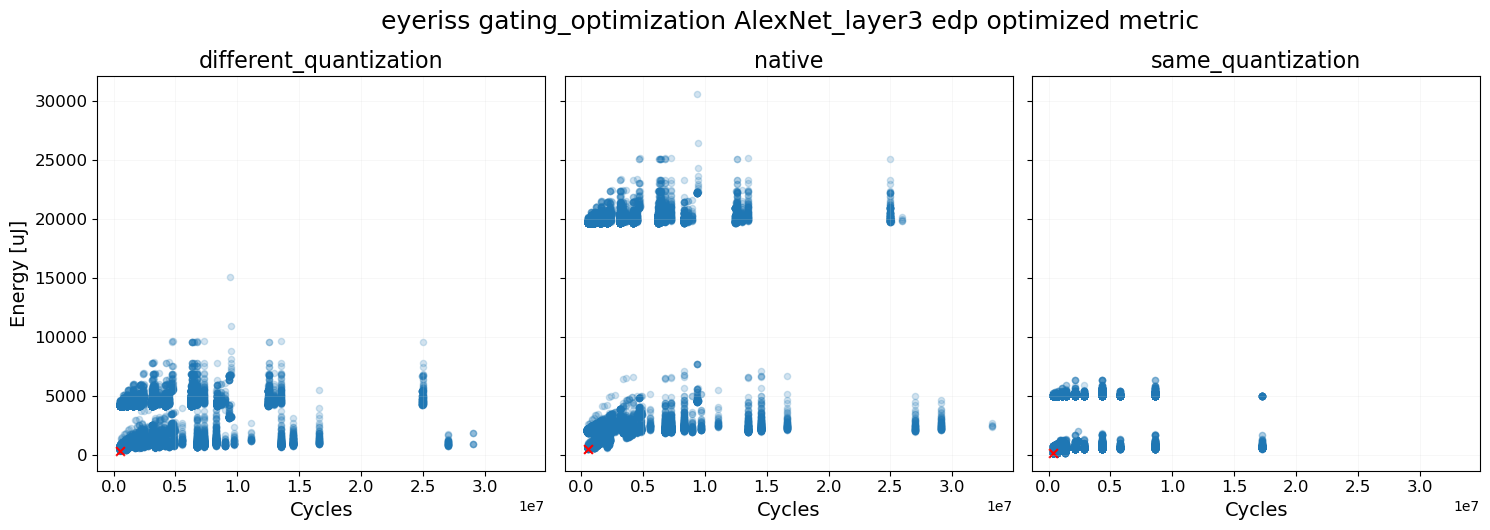

In [61]:
""" SCATTER PLOT """
### MODIFY/SELECT DATA ###
design_setting = "gating_optimization" # gating_optimization, no_optimizations
layer_choice = 'AlexNet_layer3' # AlexNet_layer1, AlexNet_layer2, AlexNet_layer3, AlexNet_layer4, AlexNet_layer5

scatter_plot_df = oaves_df.loc[(oaves_df['Layer'] == layer_choice) & (design_setting == oaves_df['Design setting'])]
best_mappings_df = stats_df.loc[(stats_df['Layer'] == layer_choice) & (design_setting == stats_df['Design setting'])]

quant_settings = scatter_plot_df['Datawidth setting'].unique()

# Find the best mapping for each quantization setting
scatter_plot_df.loc[:, 'Best'] = False
for quant_setting in quant_settings:
    quant_setting_df = scatter_plot_df[scatter_plot_df['Datawidth setting'] == quant_setting]
    best_mapping = quant_setting_df.loc[quant_setting_df['EDP [J*cycle]'].idxmin()]
    scatter_plot_df.loc[best_mapping.name, 'Best'] = True

### PLOT GRAPHS ###
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharex=True, sharey=True)

for i, setting in enumerate(quant_settings):
    sub_df = scatter_plot_df[scatter_plot_df['Datawidth setting'] == setting]
    best_df = sub_df[sub_df['Best']]
    other_df = sub_df[~sub_df['Best']]
    axes[i].scatter(other_df['Cycles'], other_df['Energy [uJ]'], s=20, alpha=0.2, c='tab:blue', rasterized=True)
    axes[i].scatter(best_df['Cycles'], best_df['Energy [uJ]'], s=40, alpha=1, c='r', marker='x', rasterized=True)    
    axes[i].set_xlabel('Cycles', fontsize=14)
    if i == 0:
        axes[i].set_ylabel('Energy [uJ]', fontsize=14)
    axes[i].set_title(setting, fontsize=16)
    axes[i].grid(True, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.25)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

#saving the graph image
plt.tight_layout()
fig_location = "plots/Experiment1"
if not os.path.exists(fig_location):
    os.makedirs(fig_location)
plt.savefig(os.path.join(fig_location, f'{arch_name}_{design_setting}_{layer_choice}_{metric}_scatter.png'), bbox_inches='tight')
plt.savefig(os.path.join(fig_location, f'{arch_name}_{design_setting}_{layer_choice}_{metric}_scatter.pdf'), bbox_inches='tight')

plt.suptitle(f"{arch_name} {design_setting} {layer_choice} {metric} optimized metric", fontsize=18, y=1.05, x=0.53)
plt.show()

In [62]:
# Get the total number of records for each quant_setting (NOTE that the numbers do not represent total number of valid mappings per setting! Because just the best evaluated mappings per thread is reported (in other words, the number is probably less than the actual number of valid mappings and will change with different number of threads used, to see true counts, run the mapper with live-status option on))
total_records = scatter_plot_df.groupby(['Datawidth setting']).size().reset_index(name='Total Records')
print(total_records.sort_values('Total Records'))

for quant_setting in quant_settings:
    quant_setting_df = scatter_plot_df[scatter_plot_df['Datawidth setting'] == quant_setting]
    best_mapping = quant_setting_df.loc[quant_setting_df['EDP [J*cycle]'].idxmin()]
    scatter_plot_df.loc[best_mapping.name, 'Best'] = True
    print(f"{quant_setting} best EDP mapping: {best_mapping['EDP [J*cycle]']} J*cycle")


        Datawidth setting  Total Records
1                  native          18079
0  different_quantization          18157
2       same_quantization          25600
different_quantization best EDP mapping: 196.334 J*cycle
native best EDP mapping: 276.511 J*cycle
same_quantization best EDP mapping: 67.58776 J*cycle


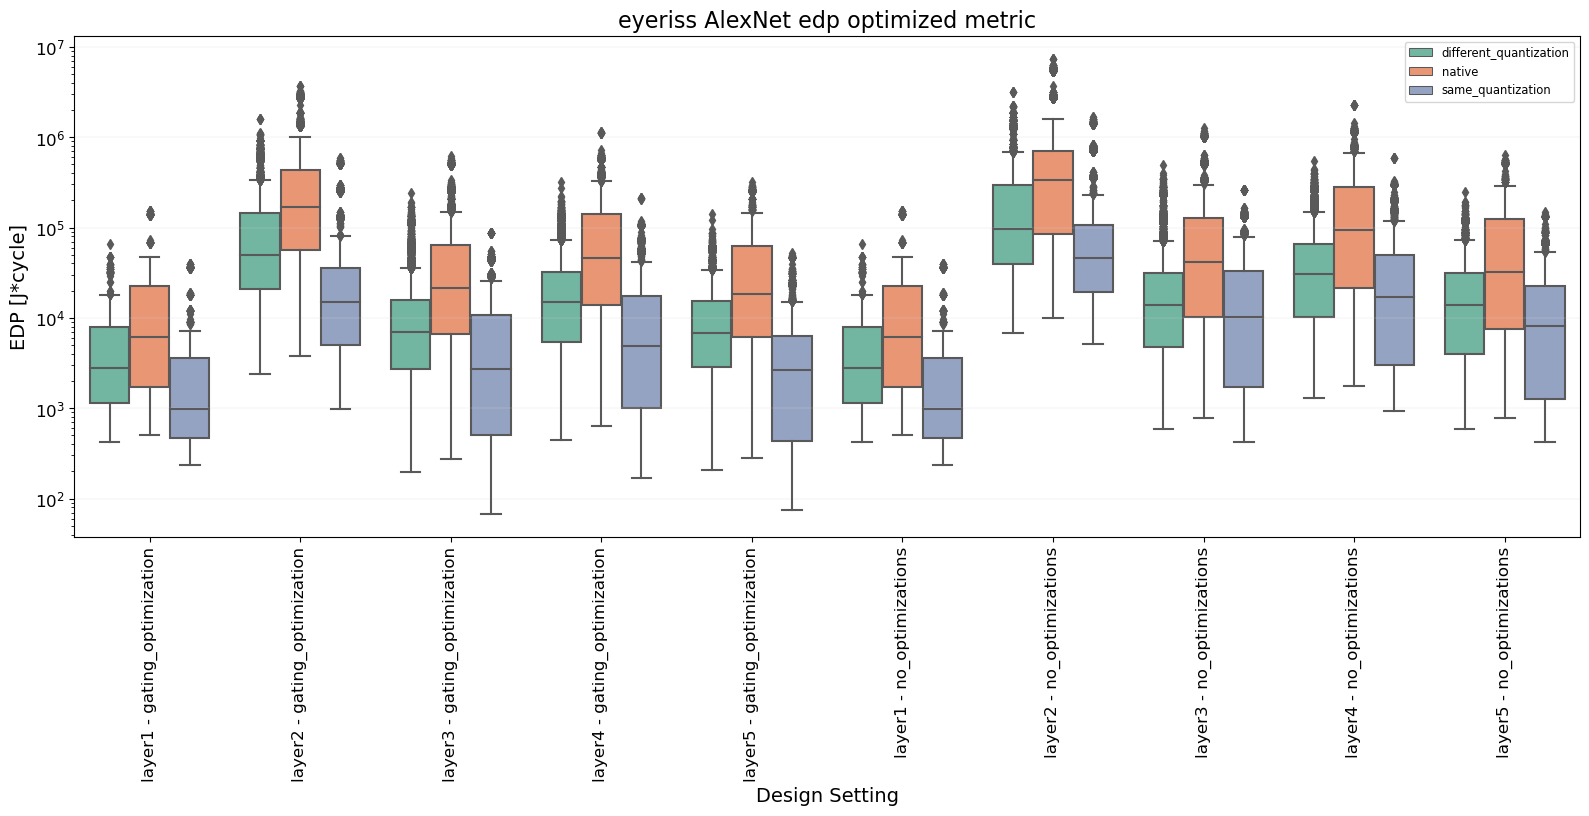

In [63]:
""" BOX PLOT """
### MODIFY/SELECT DATA ###
layers = ['AlexNet_layer1', 'AlexNet_layer2', 'AlexNet_layer3', 'AlexNet_layer4', 'AlexNet_layer5']
boxplot_df = oaves_df[oaves_df['Layer'].isin(layers)]

# Remove the "AlexNet_" part from layer names
boxplot_df['Layer'] = boxplot_df['Layer'].str.replace('AlexNet_', '')
# Create a new column to distinguish different layers
boxplot_df["Layer_Design_setting"] = boxplot_df["Layer"] + " - " + boxplot_df["Design setting"]

### PLOT GRAPHS ###
plt.figure(figsize=(16, 8))

sns.boxplot(x="Layer_Design_setting", y="EDP [J*cycle]", hue="Datawidth setting", data=boxplot_df, palette="Set2")

# Set plot labels
plt.xlabel('Design Setting', fontsize=14)
plt.ylabel('EDP [J*cycle]', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

# Set y-axis scale to logarithmic
plt.yscale('log')
# Add y-axis grid lines
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.25, alpha=0.75)
# Set legend position and font size
plt.legend(loc='upper right', fontsize='small')


# Save the plot
plt.tight_layout()
fig_location = "plots/Experiment1"
if not os.path.exists(fig_location):
    os.makedirs(fig_location)
plt.savefig(os.path.join(fig_location, f'{arch_name}_AlexNet_boxplot.png'), bbox_inches='tight')
plt.savefig(os.path.join(fig_location, f'{arch_name}_AlexNet_boxplot.pdf'), bbox_inches='tight')

plt.title(f"{arch_name} AlexNet {metric} optimized metric", fontsize=16)
plt.show()

## Experiment 2: Individual layers of VGG01 (Eyeriss_like, Simba_like; VGG01; w and w/o gating)
* Bar plots of individual VGG01 CONV layers evaluation for individual data quantization settings for chosen arch design (eyeriss or simba) and chosen optimized metric
* The considered scenario is found in the `../../scenarios/vgg01_eyeriss_simba/mapper` folder
* You can change the desired `metric`, `arch` in the code
* The VGG01 consists of 8 CONV layers and is based on a description in [Shafiee, ISCA 2016]

In [30]:
# Scenario path
scenario = "../../scenarios/vgg01_eyeriss_simba/mapper"
# Customizable parameters
metric = "edp" # edp, energy-delay, delay-energy

### RETRIEVE DATA ###
path = os.path.join(scenario)

stats_dfs = [] # stats.csv data
# Extract results from the collected stats.csv
for f in glob.glob(f"{path}/**/{metric}/**/*stats.csv", recursive=True):
    arch_name = os.path.basename(reduce_nesting_level(f, 8)).split('-')[0]
    quant_setting = os.path.basename(reduce_nesting_level(f, 7))
    mapper_name = os.path.basename(reduce_nesting_level(f, 3))
    metric_name = os.path.basename(reduce_nesting_level(f, 2))
    topology_name = os.path.basename(reduce_nesting_level(f, 1))
    layer_name = os.path.splitext(os.path.splitext(os.path.basename(f))[0])[0]
    # print(f"arch_name: {arch_name}, design_setting: {design_setting}, quant_setting: {quant_setting}, mapper_name: {mapper_name}, metric_name: {metric_name}, topology_name: {topology_name}, layer_name: {layer_name}")
       
    arch_df = pd.read_csv(f)
    arch_df['Architecture'] = arch_name
    arch_df['NN topology'] = topology_name
    arch_df['Layer'] = layer_name
    arch_df['Mapper'] = mapper_name
    arch_df['Metric'] = metric_name
    arch_df['Datawidth setting'] = quant_setting
    stats_dfs.append(arch_df)
    
stats_df = pd.concat(stats_dfs, axis=0, ignore_index=True)

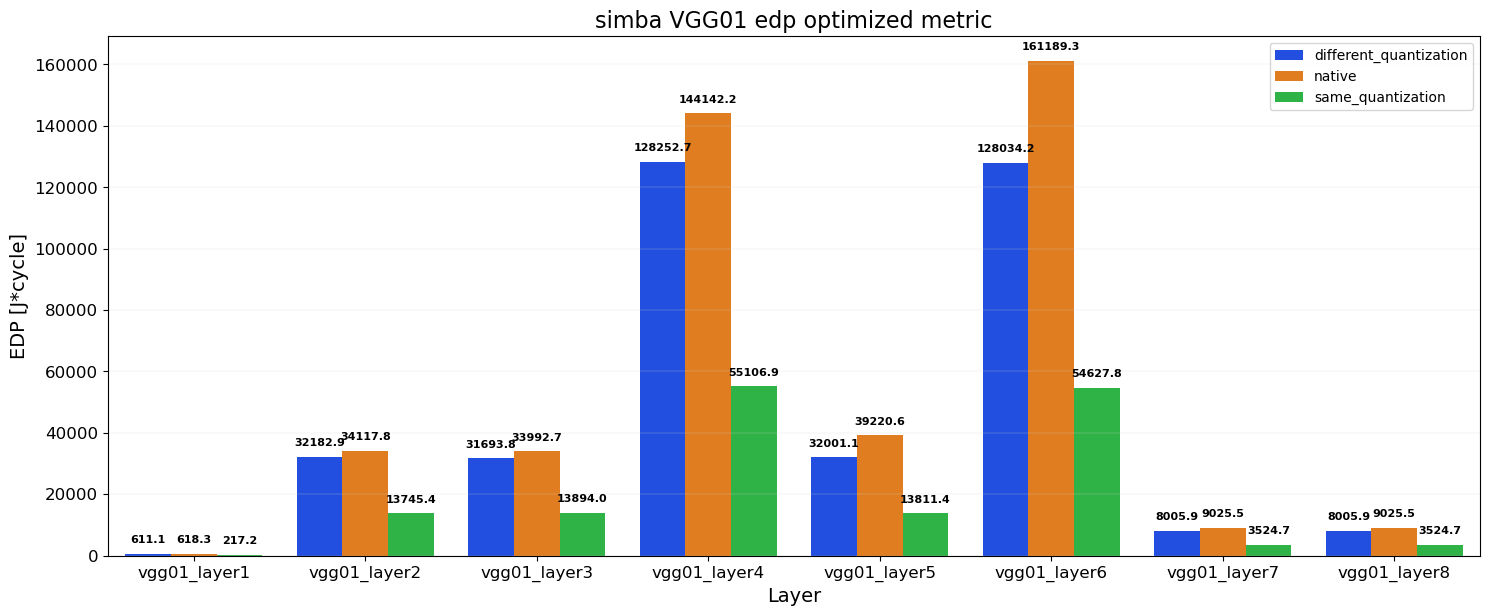

In [38]:
""" BAR PLOT """
### MODIFY/SELECT DATA ###
arch_name = "eyeriss" # eyeriss, simba
# Filter the dataframe based on the chosen architecture
barplot_df = stats_df[(stats_df['Architecture'] == arch_name)]

### PLOT GRAPHS ###
plt.figure(figsize=(15, 6))
barplot = sns.barplot(x="Layer", y="EDP [J*cycle]", hue="Datawidth setting", data=barplot_df, palette="bright")

# Add y-axis grid lines
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.25, alpha=0.75)

# Set plot labels
plt.xlabel('Layer', fontsize=14)
plt.ylabel('EDP [J*cycle]', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Set legend position and font size
plt.legend(loc='upper right')

# Loop over the bars, and add a label (the value of the bar) above each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points',
                   fontsize=8,  # Adjust the font size as desired
                   weight='bold')  # Make the font bold

# Save the plot
plt.tight_layout()
fig_location = "plots/Experiment2"
if not os.path.exists(fig_location):
    os.makedirs(fig_location)
plt.savefig(os.path.join(fig_location, f'{arch_name}_{metric}_VGG01_barplot.png'), bbox_inches='tight')
plt.savefig(os.path.join(fig_location, f'{arch_name}_{metric}_VGG01_barplot.pdf'), bbox_inches='tight')

plt.title(f"{arch_name} VGG01 {metric} optimized metric", fontsize=16)
plt.show()


## Experiment 3: Evaluation of different quantized MobileNet models (Eyeriss_like, Simba_like; w and w/o gating)
* Bar plots of individual stacked performance of different uniformly quantized MobileNet models
* In total 8 different instances are considered:
    - native 32-bit float model
    - 7 quantized model, where each uses 8-bit for activations and uniformly 2-8 bits per weight values
* The models are evaluated on different alterations of eyeriss and simba architecture (for more details, see the respective `README.md` in the scenario folder)
* The considered scenario is found in the `../../scenarios/trained_mobilenet_eval` folder
* You can change the desired `arch` in the code
* For reference validation accuracy, see `ref_trained_models_perf.txt`

In [42]:
# Scenario path
scenario = "../../scenarios/trained_mobilenet_eval"
### RETRIEVE DATA ###
path = os.path.join(scenario)

native_stats_dfs = [] # original float model stats.csv data
quant_stats_dfs = []  # quantized int model stats.csv data
# Extract results from the native model's stats.csv
for f in glob.glob(f"{path}/**/original_float_data/**/*stats.csv", recursive=True):
    arch_name = os.path.basename(reduce_nesting_level(f, 9)).split('-')[0]
    mapper_name = os.path.basename(reduce_nesting_level(f, 5))
    metric_name = os.path.basename(reduce_nesting_level(f, 4))
    design_setting = os.path.basename(reduce_nesting_level(f, 3))
    topology_name = os.path.basename(reduce_nesting_level(f, 2))
    quant_setting = os.path.basename(reduce_nesting_level(f, 1))
    layer_name = os.path.splitext(os.path.splitext(os.path.basename(f))[0])[0]
    # print(f"arch_name: {arch_name}, design_setting: {design_setting}, quant_setting: {quant_setting}, mapper_name: {mapper_name}, metric_name: {metric_name}, topology_name: {topology_name}, layer_name: {layer_name}")
       
    arch_df = pd.read_csv(f)
    arch_df['Architecture'] = arch_name
    arch_df['Design setting'] = design_setting
    arch_df['NN topology'] = topology_name
    arch_df['Layer'] = layer_name
    arch_df['Mapper'] = mapper_name
    arch_df['Metric'] = metric_name
    arch_df['Datawidth setting'] = quant_setting
    native_stats_dfs.append(arch_df)
    
native_stats_df = pd.concat(native_stats_dfs, axis=0, ignore_index=True)

# Extract results from the native model's stats.csv
for f in glob.glob(f"{path}/**/quantized_data/**/*stats.csv", recursive=True):
    arch_name = os.path.basename(reduce_nesting_level(f, 10)).split('-')[0]
    mapper_name = os.path.basename(reduce_nesting_level(f, 5))
    metric_name = os.path.basename(reduce_nesting_level(f, 4))
    design_setting = os.path.basename(reduce_nesting_level(f, 3))
    topology_name = os.path.basename(reduce_nesting_level(f, 2))
    quant_setting = os.path.basename(reduce_nesting_level(f, 1))
    layer_name = os.path.splitext(os.path.splitext(os.path.basename(f))[0])[0]
    # print(f"arch_name: {arch_name}, design_setting: {design_setting}, quant_setting: {quant_setting}, mapper_name: {mapper_name}, metric_name: {metric_name}, topology_name: {topology_name}, layer_name: {layer_name}")
       
    arch_df = pd.read_csv(f)
    arch_df['Architecture'] = arch_name
    arch_df['Design setting'] = design_setting
    arch_df['NN topology'] = topology_name
    arch_df['Layer'] = layer_name
    arch_df['Mapper'] = mapper_name
    arch_df['Metric'] = metric_name
    arch_df['Datawidth setting'] = quant_setting
    quant_stats_dfs.append(arch_df)
    
quant_stats_df = pd.concat(quant_stats_dfs, axis=0, ignore_index=True)

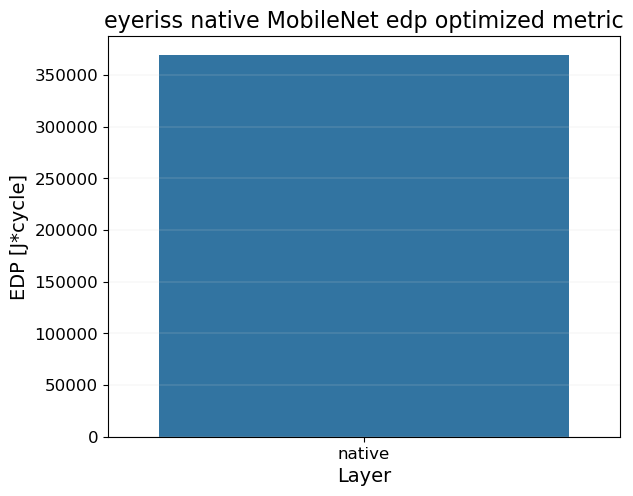

In [43]:
""" BAR PLOT NATIVE WHOLE MODEL """
### MODIFY/SELECT DATA ###
arch_name = "eyeriss"    # "eyeriss", "simba"
# Filter the dataframe based on the chosen architecture
barplot_df = native_stats_df[(native_stats_df['Architecture'] == arch_name)]

# Group the data by design setting and datawidth setting, and sum the EDP values
barplot_df = barplot_df.groupby(['Design setting', 'Datawidth setting']).sum().reset_index()

### PLOT GRAPHS ###
plt.figure(figsize=(6.4, 4.8))
sns.barplot(x="Datawidth setting", y="EDP [J*cycle]", data=barplot_df)

# Add y-axis grid lines
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.25, alpha=0.75)

# Set plot labels
plt.xlabel('Layer', fontsize=14)
plt.ylabel('EDP [J*cycle]', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the plot
plt.tight_layout()
fig_location = "plots/Experiment3"
if not os.path.exists(fig_location):
    os.makedirs(fig_location)
plt.savefig(os.path.join(fig_location, f'{arch_name}_edp_native_MobileNet_barplot.png'), bbox_inches='tight')
plt.savefig(os.path.join(fig_location, f'{arch_name}_edp_native_MobileNet_barplot.pdf'), bbox_inches='tight')

plt.title(f"{arch_name} native MobileNet edp optimized metric", fontsize=16)
plt.show()

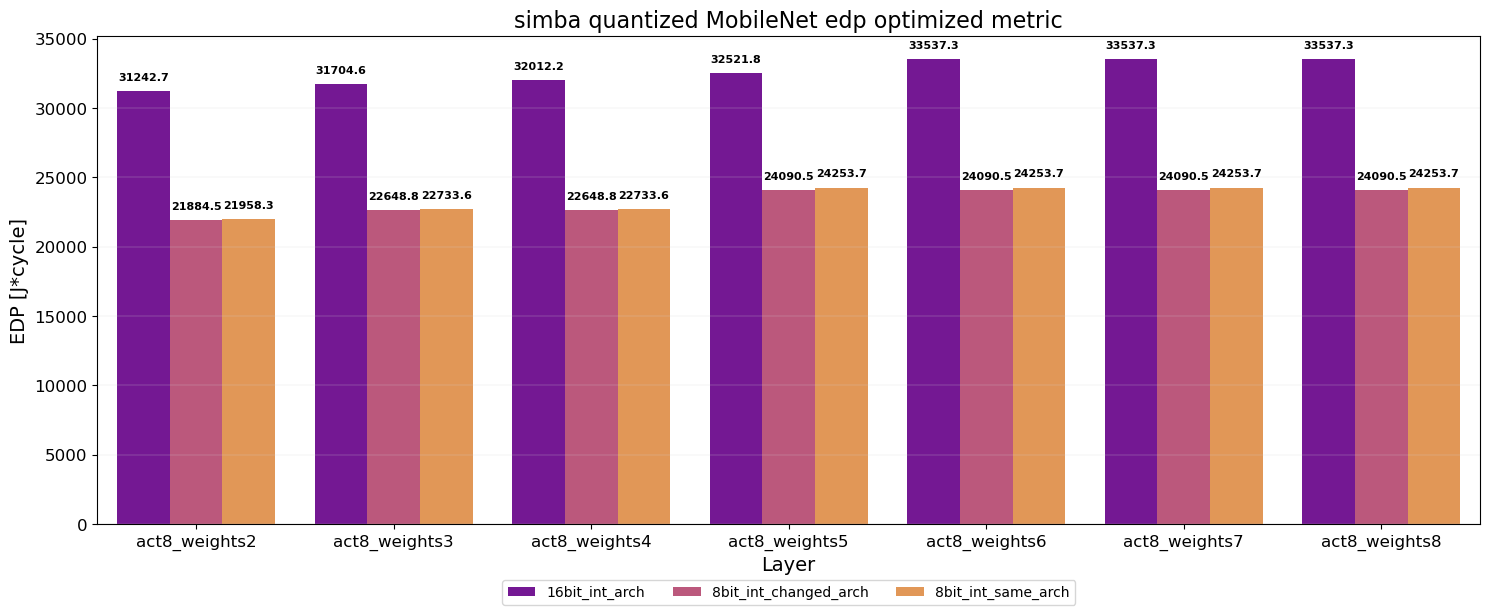

In [53]:
""" BAR PLOT QUANTIZED WHOLE MODELS """
### MODIFY/SELECT DATA ###
arch_name = "simba"    # "eyeriss", "simba"
# Filter the dataframe based on the chosen architecture
barplot_df = quant_stats_df[(quant_stats_df['Architecture'] == arch_name)]

# Group the data by design setting and datawidth setting, and sum the EDP values
barplot_df = barplot_df.groupby(['Design setting', 'Datawidth setting']).sum().reset_index()

### PLOT GRAPHS ###
plt.figure(figsize=(15, 6))
barplot = sns.barplot(x="Datawidth setting", y="EDP [J*cycle]", hue="Design setting", data=barplot_df, palette="plasma")

# Add y-axis grid lines
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.25, alpha=0.75)

# Set plot labels
plt.xlabel('Layer', fontsize=14)
plt.ylabel('EDP [J*cycle]', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Set legend position and font size
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

# Loop over the bars, and add a label (the value of the bar) above each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points',
                   fontsize=8,  # Adjust the font size as desired
                   weight='bold')  # Make the font bold

# Save the plot
plt.tight_layout()
fig_location = "plots/Experiment3"
if not os.path.exists(fig_location):
    os.makedirs(fig_location)
plt.savefig(os.path.join(fig_location, f'{arch_name}_edp_quant_MobileNet_barplot.png'), bbox_inches='tight')
plt.savefig(os.path.join(fig_location, f'{arch_name}_edp_quant_MobileNet_barplot.pdf'), bbox_inches='tight')

plt.title(f"{arch_name} quantized MobileNet edp optimized metric", fontsize=16)
plt.show()

/tmp/ipykernel_7263/3871768266.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barplot_df["Layer"] = pd.Categorical(barplot_df["Layer"], categories=layer_order, ordered=True)


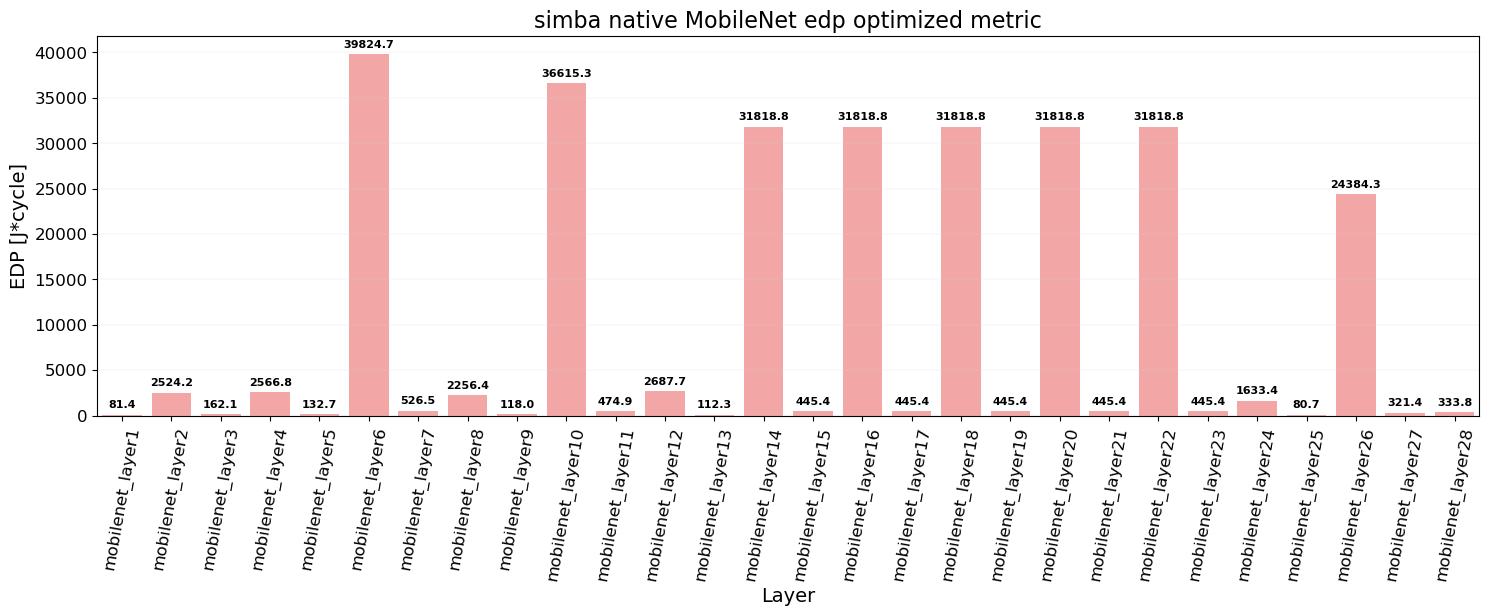

In [76]:
""" BAR PLOT NATIVE MODEL LAYERS """
### MODIFY/SELECT DATA ###
arch_name = "simba"    # "eyeriss", "simba"

# Filter the dataframe based on the chosen architecture
barplot_df = native_stats_df[(native_stats_df['Architecture'] == arch_name)]

# Convert the 'Layer' column to an ordered categorical variable
layer_order = [f"mobilenet_layer{i}" for i in range(1,29)]
barplot_df["Layer"] = pd.Categorical(barplot_df["Layer"], categories=layer_order, ordered=True)

### PLOT GRAPHS ###
plt.figure(figsize=(15, 6))
pastel_red = (255/255, 153/255, 153/255)
barplot = sns.barplot(x="Layer", y="EDP [J*cycle]", data=barplot_df, color=pastel_red)

# Add y-axis grid lines
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.25, alpha=0.75)

# Set plot labels
plt.xlabel('Layer', fontsize=14)
plt.ylabel('EDP [J*cycle]', fontsize=14)
plt.xticks(rotation=80, fontsize=12)
plt.yticks(fontsize=12)

# Loop over the bars, and add a label (the value of the bar) above each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 7), 
                   textcoords = 'offset points',
                   fontsize=8,  # Adjust the font size as desired
                   weight='bold')  # Make the font bold

# Save the plot
plt.tight_layout()
fig_location = "plots/Experiment3"
if not os.path.exists(fig_location):
    os.makedirs(fig_location)
plt.savefig(os.path.join(fig_location, f'{arch_name}_edp_native_MobileNet_layers_barplot.png'), bbox_inches='tight')
plt.savefig(os.path.join(fig_location, f'{arch_name}_edp_native_MobileNet_layers_barplot.pdf'), bbox_inches='tight')

plt.title(f"{arch_name} native MobileNet edp optimized metric", fontsize=16)
plt.show()

/tmp/ipykernel_7263/1415547806.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barplot_df["Layer"] = pd.Categorical(barplot_df["Layer"], categories=layer_order, ordered=True)


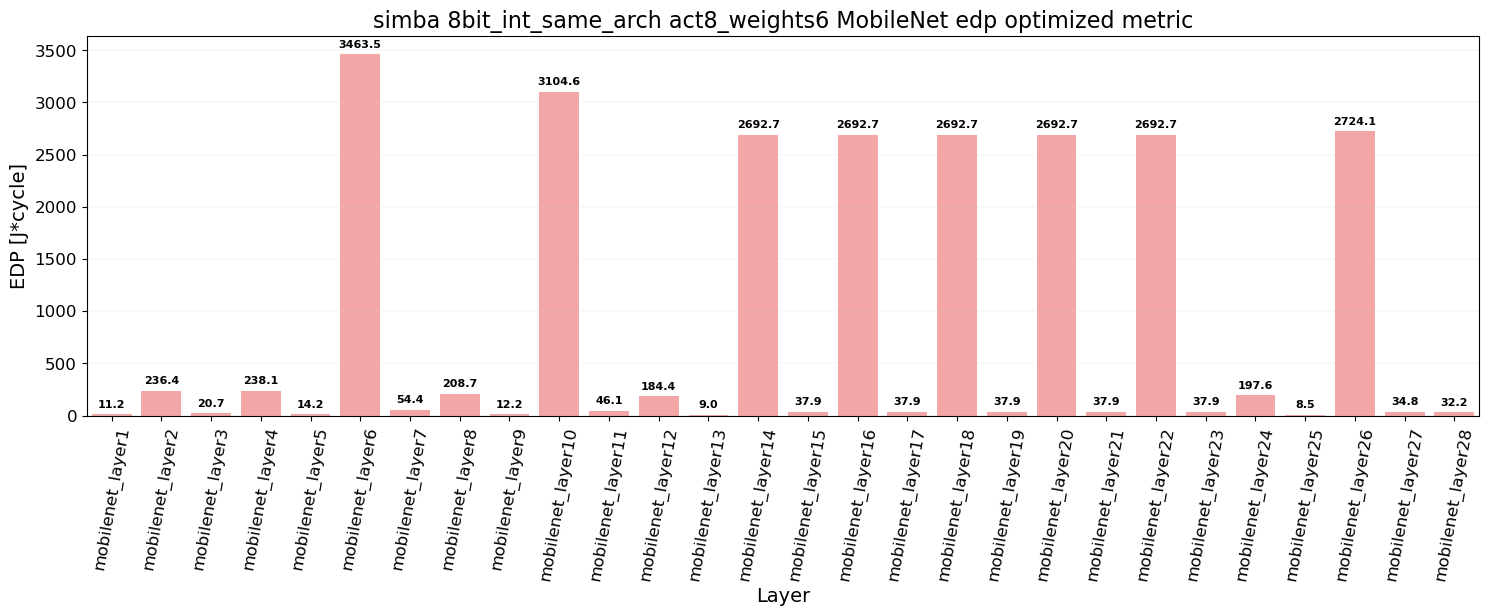

In [78]:
""" BAR PLOT QUANTIZED MODEL LAYERS """
### MODIFY/SELECT DATA ###
arch_name = "simba"    # "eyeriss", "simba"
design_choice = "16bit_int_arch"    # "8bit_int_changed_arch", "8bit_int_same_arch", "16bit_int_arch"
quant_choice = "act8_weights6"    # "act8_weights2", "act8_weights3", "act8_weights4", "act8_weights5", "act8_weights6", "act8_weights7", "act8_weights8"

# Filter the dataframe based on the chosen architecture
barplot_df = quant_stats_df[(quant_stats_df['Architecture'] == arch_name) & (quant_stats_df['Design setting'] == design_choice) & (quant_stats_df['Datawidth setting'] == quant_choice)]

# Convert the 'Layer' column to an ordered categorical variable
layer_order = [f"mobilenet_layer{i}" for i in range(1,29)]
barplot_df["Layer"] = pd.Categorical(barplot_df["Layer"], categories=layer_order, ordered=True)

### PLOT GRAPHS ###
plt.figure(figsize=(15, 6))
pastel_red = (255/255, 153/255, 153/255)
barplot = sns.barplot(x="Layer", y="EDP [J*cycle]", data=barplot_df, color=pastel_red)

# Add y-axis grid lines
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.25, alpha=0.75)

# Set plot labels
plt.xlabel('Layer', fontsize=14)
plt.ylabel('EDP [J*cycle]', fontsize=14)
plt.xticks(rotation=80, fontsize=12)
plt.yticks(fontsize=12)

# Loop over the bars, and add a label (the value of the bar) above each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 7), 
                   textcoords = 'offset points',
                   fontsize=8,  # Adjust the font size as desired
                   weight='bold')  # Make the font bold

# Save the plot
plt.tight_layout()
fig_location = "plots/Experiment3"
if not os.path.exists(fig_location):
    os.makedirs(fig_location)
plt.savefig(os.path.join(fig_location, f'{arch_name}_{design_choice}_edp_quant_MobileNet_{quant_choice}_layers_barplot.png'), bbox_inches='tight')
plt.savefig(os.path.join(fig_location, f'{arch_name}_{design_choice}_edp_quant_MobileNet_{quant_choice}_layers_barplot.pdf'), bbox_inches='tight')

plt.title(f"{arch_name} {design_choice} {quant_choice} MobileNet edp optimized metric", fontsize=16)
plt.show()

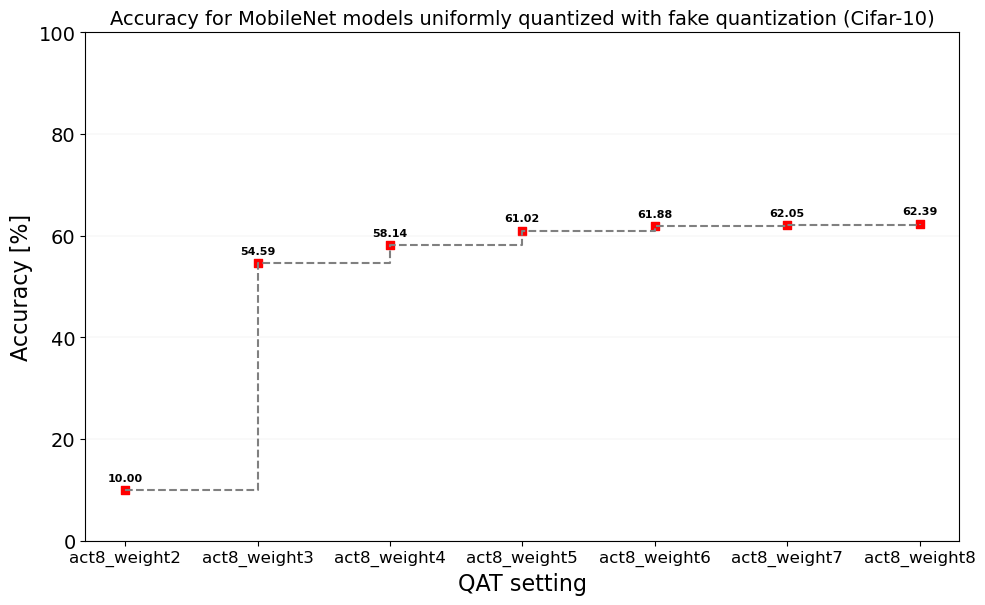

In [55]:
" ACCURACY PLOT "
### MODIFY/SELECT DATA ###
# "original_float32": 61.40
data = {
    "act8_weight2": 10.00,
    "act8_weight3": 54.59,
    "act8_weight4": 58.14,
    "act8_weight5": 61.02,
    "act8_weight6": 61.88,
    "act8_weight7": 62.05,
    "act8_weight8": 62.39
}

# Sorting the dictionary by keys (this step is important for the step plot)
sorted_keys = sorted(data.keys())
sorted_values = [data[key] for key in sorted_keys]

### PLOT GRAPHS ###
plt.figure(figsize=(10, 6))
plt.step(sorted_keys, sorted_values, color="grey", where='post', linestyle='--')
plt.scatter(sorted_keys, sorted_values, color='red', marker='s')

# Loop over the keys and values in the data dictionary
for key, value in data.items():
    plt.annotate(f"{value:.2f}", (key, value), ha='center', va='bottom', fontsize=8, weight='bold', xytext=(0, 5), textcoords='offset points')

plt.xticks(fontsize=12)
plt.yticks(range(0, 101, 20), fontsize=14)
plt.xlabel("QAT setting", fontsize=16)
plt.ylabel("Accuracy [%]", fontsize=16)
# Add y-axis grid lines
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.25, alpha=0.75)
plt.grid(axis='x', linewidth=0)

# Save the plot
plt.tight_layout()
fig_location = "plots/Experiment3"
if not os.path.exists(fig_location):
    os.makedirs(fig_location)
plt.savefig(os.path.join(fig_location, f'accuracy_step_plot_quantized_MobileNet.png'), bbox_inches='tight')
plt.savefig(os.path.join(fig_location, f'accuracy_step_plot_quantized_MobileNet.pdf'), bbox_inches='tight')

plt.title(f"Accuracy for MobileNet models uniformly quantized with fake quantization (Cifar-10)", fontsize=14)
plt.show()